In [12]:
# Only run this cell if you actually have the statistical data
import numpy as np
from scepter import scenario
from scepter.angle_sampler import JointAngleSampler

results = scenario.read_data("simulation_results_Elev_sysC_highElev-AdjShift.h5")
sat_beta = results["iter"]["sat_beta"]
sat_alpha = results["iter"]["sat_alpha"]

sampler = JointAngleSampler.from_recovered(
    sat_beta, sat_alpha,
    beta_bins=900,
    alpha_bins=3600,
    smooth_sigma_beta=0.6,
    smooth_sigma_alpha=0.8,
    show_comparison=False,
    histogram="auto",
)

sampler.save("joint_sampler_sysC_highElev_adjShift.npz")

In [15]:
import numpy as np
from scepter import scenario
from scepter.angle_sampler import JointAngleSampler

sampler = JointAngleSampler.load("joint_sampler_sysC_highElev_adjShift.npz")

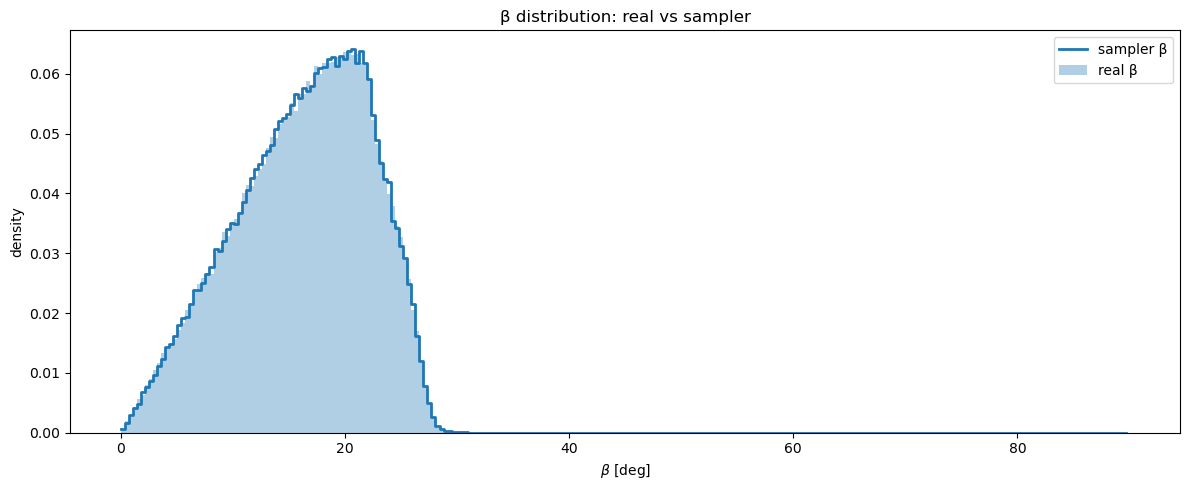

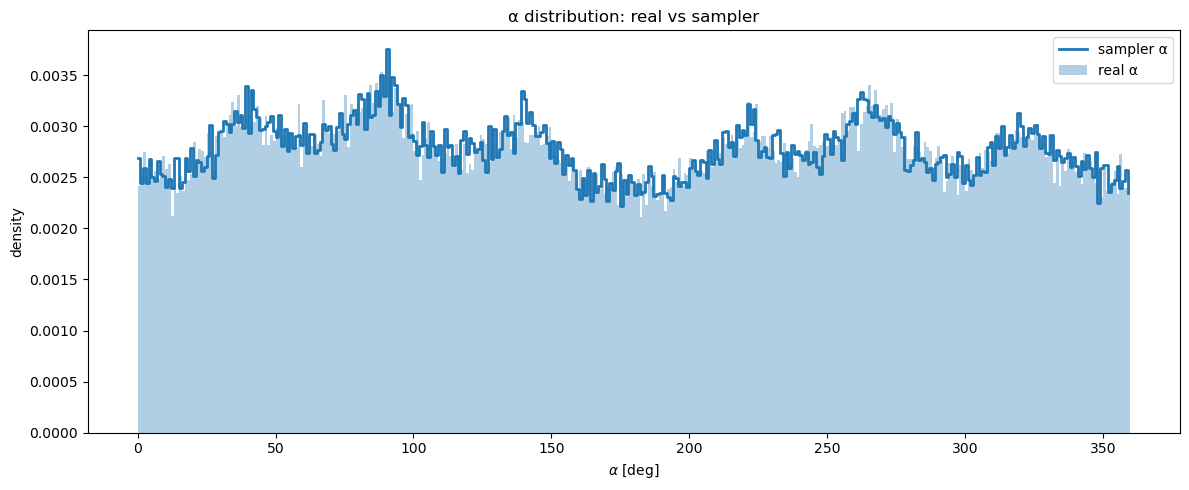

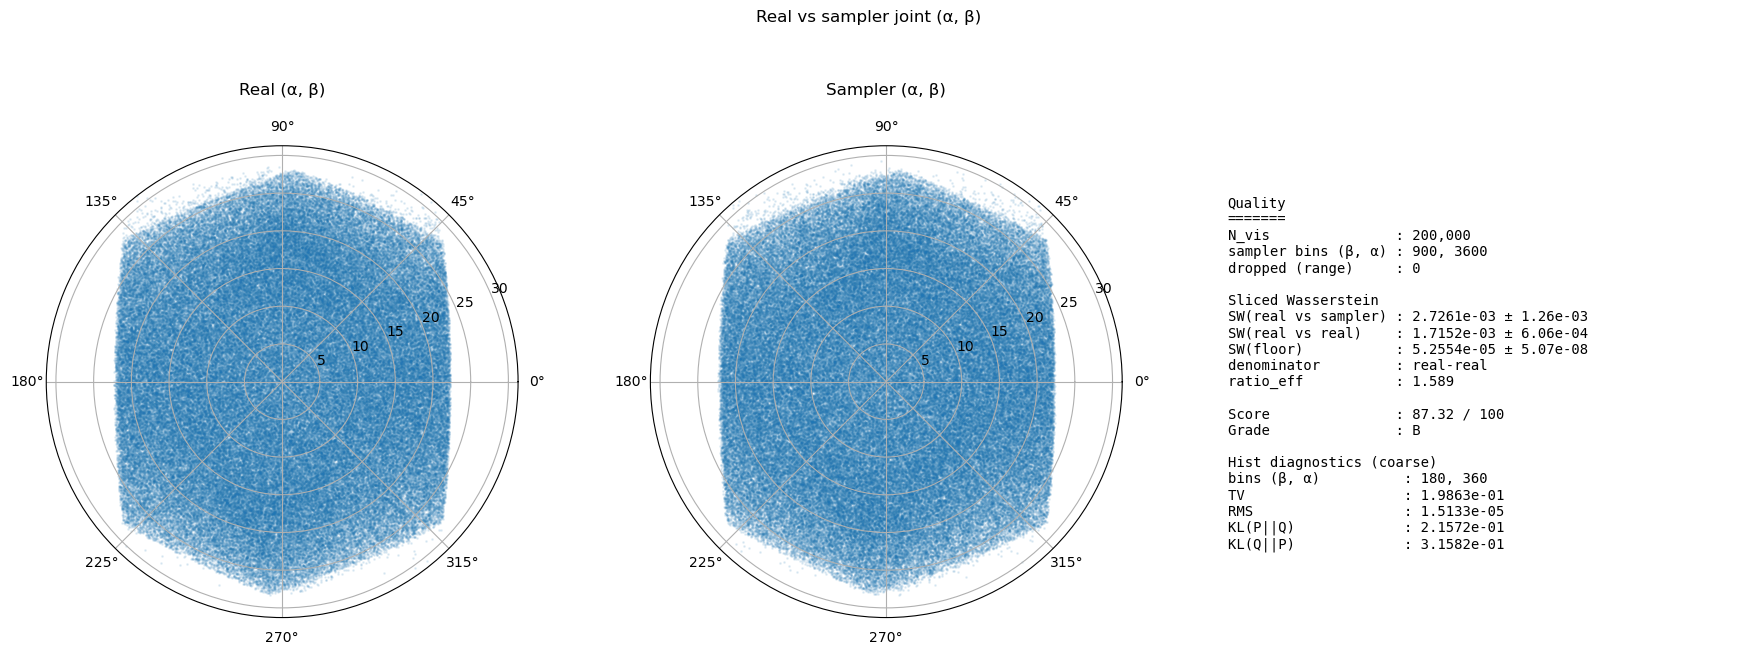

In [16]:
metrics=sampler.show_comparison(sat_beta, sat_alpha, 
                                n_vis=200_000, n_slices=64, 
                                baseline_trials=10, auto_ratio_scale=True, 
                                save_prefix="highElev-AdjShift", )

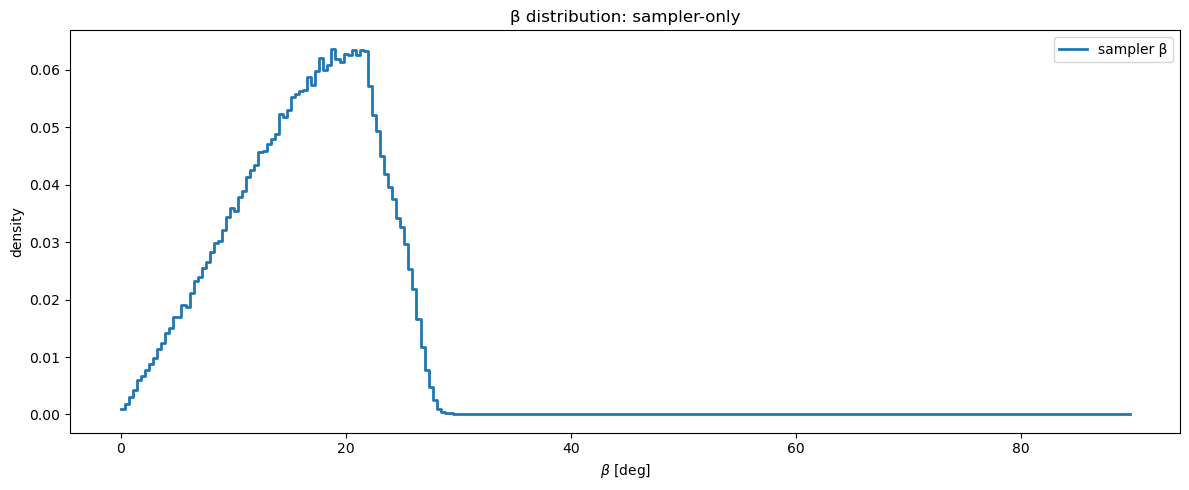

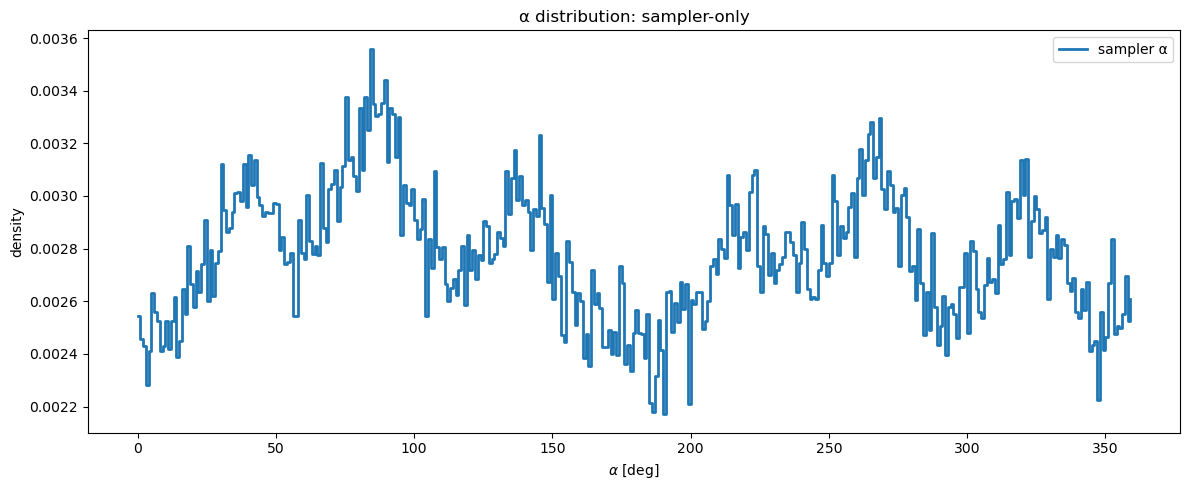

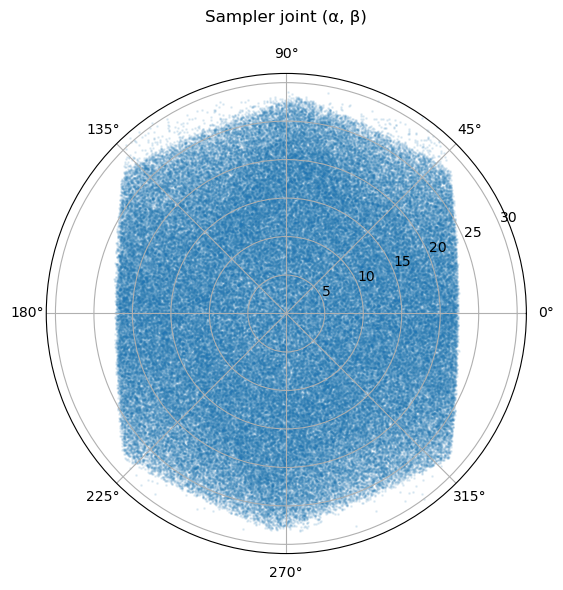

In [14]:
# sampler_only_visualise.py
import numpy as np
import matplotlib.pyplot as plt

from scepter.angle_sampler import JointAngleSampler


def plot_sampler_only(
    sampler: JointAngleSampler,
    *,
    n_vis: int = 200_000,
    seed: int = 42,
    plot_beta_bins: int = 250,
    plot_alpha_bins: int = 360,
    save_prefix: str | None = None,
) -> None:
    """
    Visualize the sampler's own (alpha, beta) distribution without any real data.

    Plots:
      1) 1D beta histogram (density)
      2) 1D alpha histogram (density)
      3) Polar scatter plot of (alpha, beta)

    Parameters
    ----------
    sampler:
        Loaded JointAngleSampler instance (minimal or full).
    n_vis:
        Number of samples to draw for visualization.
    seed:
        RNG seed for reproducibility.
    plot_beta_bins:
        Number of bins for 1D beta plot.
    plot_alpha_bins:
        Number of bins for 1D alpha plot.
    save_prefix:
        If provided, saves figures as:
          {prefix}_beta_1d.png
          {prefix}_alpha_1d.png
          {prefix}_joint_polar.png
    """
    rng = np.random.default_rng(int(seed))

    # Draw samples from the sampler
    beta_s, alpha_s = sampler.sample(rng, size=int(n_vis))

    # -------------------------
    # 1D beta distribution
    # -------------------------
    beta_edges = np.linspace(
        sampler.beta_range[0],
        sampler.beta_range[1],
        int(plot_beta_bins) + 1,
        dtype=np.float64,
    )
    beta_counts, _ = np.histogram(beta_s, bins=beta_edges)
    beta_w = np.diff(beta_edges)
    beta_density = beta_counts / (beta_counts.sum() * beta_w)

    fig1 = plt.figure(figsize=(12, 5))
    ax = fig1.add_subplot(1, 1, 1)
    ax.step(beta_edges[:-1], beta_density, where="post", linewidth=2.0, label="sampler β")
    ax.set_xlabel(r"$\beta$ [deg]")
    ax.set_ylabel("density")
    ax.set_title("β distribution: sampler-only")
    ax.legend()
    fig1.tight_layout()
    if save_prefix:
        fig1.savefig(f"{save_prefix}_beta_1d.png", dpi=200)

    # -------------------------
    # 1D alpha distribution
    # -------------------------
    alpha_edges = np.linspace(
        sampler.alpha_range[0],
        sampler.alpha_range[1],
        int(plot_alpha_bins) + 1,
        dtype=np.float64,
    )
    alpha_counts, _ = np.histogram(alpha_s, bins=alpha_edges)
    alpha_w = np.diff(alpha_edges)
    alpha_density = alpha_counts / (alpha_counts.sum() * alpha_w)

    fig2 = plt.figure(figsize=(12, 5))
    ax = fig2.add_subplot(1, 1, 1)
    ax.step(alpha_edges[:-1], alpha_density, where="post", linewidth=2.0, label="sampler α")
    ax.set_xlabel(r"$\alpha$ [deg]")
    ax.set_ylabel("density")
    ax.set_title("α distribution: sampler-only")
    ax.legend()
    fig2.tight_layout()
    if save_prefix:
        fig2.savefig(f"{save_prefix}_alpha_1d.png", dpi=200)

    # -------------------------
    # Polar joint visualization
    # -------------------------
    phi = np.deg2rad(alpha_s.astype(np.float64, copy=False))
    r = beta_s.astype(np.float64, copy=False)

    fig3 = plt.figure(figsize=(12, 6))
    ax = fig3.add_subplot(1, 1, 1, projection="polar")
    ax.scatter(phi, r, s=1, alpha=0.1)
    ax.set_title("Sampler joint (α, β)", pad=18)

    r_max = float(np.max(r)) if r.size else 1.0
    ax.set_rlim(0.0, r_max)

    fig3.tight_layout()
    if save_prefix:
        fig3.savefig(f"{save_prefix}_joint_polar.png", dpi=200)

    plt.show()


if __name__ == "__main__":
    sampler = JointAngleSampler.load("joint_sampler_sysC_highElev_adjShift.npz", mode="minimal")

    plot_sampler_only(
        sampler,
        n_vis=200_000,
        seed=42,
        plot_beta_bins=250,
        plot_alpha_bins=360,
        save_prefix="random_pointing_sampler_only",
    )
